<a href="https://colab.research.google.com/github/mohanaditya910/eip-season4-batch1/blob/master/Week5/submission1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# mount gdrive and unzip data
from google.colab import drive
drive.mount('/content/drive')
!unzip -q "/content/drive/My Drive/hvc_data.zip"
# look for `hvc_annotations.csv` file and `resized` dir
%ls 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
drive/  hvc_annotations.csv  resized/  sample_data/


In [2]:
%tensorflow_version 1.x

import cv2
import json

import numpy as np
import pandas as pd

from functools import partial
from pathlib import Path 
from tqdm import tqdm

from google.colab.patches import cv2_imshow

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder


from keras.applications import VGG16
from keras.layers.core import Dropout
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.layers import Input
from keras.models import Model
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator


Using TensorFlow backend.


In [3]:
# load annotations
df = pd.read_csv("hvc_annotations.csv")
del df["filename"] # remove unwanted column
df.head()

,gender,imagequality,age,weight,carryingbag,footwear,emotion,bodypose,image_path
0,male,Average,35-45,normal-healthy,Grocery/Home/Plastic Bag,Normal,Neutral,Front-Frontish,resized/1.jpg
1,female,Average,35-45,over-weight,None,Normal,Angry/Serious,Front-Frontish,resized/2.jpg
2,male,Good,45-55,normal-healthy,Grocery/Home/Plastic Bag,CantSee,Neutral,Front-Frontish,resized/3.jpg
3,male,Good,45-55,normal-healthy,Daily/Office/Work Bag,Normal,Neutral,Front-Frontish,resized/4.jpg
4,female,Good,35-45,slightly-overweight,None,CantSee,Neutral,Front-Frontish,resized/5.jpg


In [4]:
# one hot encoding of labels

one_hot_df = pd.concat([
    df[["image_path"]],
    pd.get_dummies(df.gender, prefix="gender"),
    pd.get_dummies(df.imagequality, prefix="imagequality"),
    pd.get_dummies(df.age, prefix="age"),
    pd.get_dummies(df.weight, prefix="weight"),
    pd.get_dummies(df.carryingbag, prefix="carryingbag"),
    pd.get_dummies(df.footwear, prefix="footwear"),
    pd.get_dummies(df.emotion, prefix="emotion"),
    pd.get_dummies(df.bodypose, prefix="bodypose"),
], axis = 1)

one_hot_df.head().T

,0,1,2,3,4
image_path,resized/1.jpg,resized/2.jpg,resized/3.jpg,resized/4.jpg,resized/5.jpg
gender_female,0,1,0,0,1
gender_male,1,0,1,1,0
imagequality_Average,1,1,0,0,0
imagequality_Bad,0,0,0,0,0
imagequality_Good,0,0,1,1,1
age_15-25,0,0,0,0,0
age_25-35,0,0,0,0,0
age_35-45,1,1,0,0,1
age_45-55,0,0,1,1,0


In [0]:
import keras
import numpy as np
import cv2
import imgaug as ia
import imgaug.augmenters as iaa

# Label columns per attribute
_gender_cols_ = [col for col in one_hot_df.columns if col.startswith("gender")]
_imagequality_cols_ = [col for col in one_hot_df.columns if col.startswith("imagequality")]
_age_cols_ = [col for col in one_hot_df.columns if col.startswith("age")]
_weight_cols_ = [col for col in one_hot_df.columns if col.startswith("weight")]
_carryingbag_cols_ = [col for col in one_hot_df.columns if col.startswith("carryingbag")]
_footwear_cols_ = [col for col in one_hot_df.columns if col.startswith("footwear")]
_emotion_cols_ = [col for col in one_hot_df.columns if col.startswith("emotion")]
_bodypose_cols_ = [col for col in one_hot_df.columns if col.startswith("bodypose")]

class PersonDataGenerator(keras.utils.Sequence):
    """Ground truth data generator"""

    
    def __init__(self, df, batch_size=64, shuffle=True,augmentation=None):################################################################
        self.df = df
        self.batch_size=batch_size
        self.shuffle = shuffle
        self.on_epoch_end()
        self.augmentation = augmentation

    def __len__(self):
        return int(np.floor(self.df.shape[0] / self.batch_size))





##################################cutout######################################

    def Cutout_process(self,img,n_holes=1,length=112):
        #h = img.size(1)
        #w = img.size(2)
        mean_0=np.mean(img[:,:,0][img[:,:,0]>0])
        mean_1=np.mean(img[:,:,1][img[:,:,1]>0])
        mean_2=np.mean(img[:,:,2][img[:,:,2]>0])
        
        border=112
        img= cv2.copyMakeBorder(img,border,border,border,border,cv2.BORDER_CONSTANT,value=[0,0,0])

        h,w,c=img.shape


        for n in range(n_holes):
          y = np.random.randint(h)
          x = np.random.randint(w)

          y1 = np.clip(y - length // 2, 0, h)
          y2 = np.clip(y + length // 2, 0, h)
          x1 = np.clip(x - length // 2, 0, w)
          x2 = np.clip(x + length // 2, 0, w)
          
          img[y1: y2, x1: x2,:] = [mean_0,mean_1,mean_2]

          img=img[112:336,112:336,:]	
          #print(img.shape)
          #cv2_imshow(img)
      
        return img

    def overall_cutout(self,images,batch_size=64):
      #64,224,224,3

      ############################################################
        images = np.stack([self.Cutout_process(images[i],n_holes=1,length=112) for i in range(64)])
        return images


    def __getitem__(self, index):
        """fetch batched images and targets"""
        #print(index)
        batch_slice = slice(index * self.batch_size, (index + 1) * self.batch_size)
        items = self.df.iloc[batch_slice]
        image = np.stack([cv2.imread(item["image_path"]) for _, item in items.iterrows()])
        #image=image/255.0
        target = {
            "gender_output": items[_gender_cols_].values,
            "image_quality_output": items[_imagequality_cols_].values,
            "age_output": items[_age_cols_].values,
            "weight_output": items[_weight_cols_].values,
            "bag_output": items[_carryingbag_cols_].values,
            "pose_output": items[_bodypose_cols_].values,
            "footwear_output": items[_footwear_cols_].values,
            "emotion_output": items[_emotion_cols_].values,
        }
        
        if self.augmentation==True:

            images_aug=self.overall_cutout(image)
            #cv2_imshow(image[0])


            sometimes = lambda aug: iaa.Sometimes(0.3, aug)

            seq = iaa.Sequential([
                                iaa.Fliplr(0.3),iaa.Flipud(0.2),
                                sometimes(iaa.Affine(
                                                     scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                                                     translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
                                                     rotate=(-45, 45),
                                                     shear=(-16, 16),
                                                     order=[0, 1],
                                                     
                                                     mode=ia.ALL
        ))
                                 ],random_order=True
                                 )
         
            image = seq(images=images_aug)
            #cv2_imshow(images_aug[0])
            #print(len(image[0][image[0]>0]))
            
        image=image/255.0  
        ##############
        mean_0=np.mean(image[:,:,:,0][image[:,:,:,0]>0])
        mean_1=np.mean(image[:,:,:,1][image[:,:,:,1]>0])
        mean_2=np.mean(image[:,:,:,2][image[:,:,:,2]>0])

        std_0=np.std(image[:,:,:,0][image[:,:,:,0]>0])
        std_1=np.std(image[:,:,:,1][image[:,:,:,1]>0])
        std_2=np.std(image[:,:,:,2][image[:,:,:,2]>0])

        image[:,:,:,0][image[:,:,:,0]>0]= (image[:,:,:,0][image[:,:,:,0]>0]-mean_0)/std_0
        image[:,:,:,1][image[:,:,:,1]>0]= (image[:,:,:,1][image[:,:,:,1]>0]-mean_0)/std_1
        image[:,:,:,2][image[:,:,:,2]>0]= (image[:,:,:,2][image[:,:,:,2]>0]-mean_0)/std_2


        ##############
        return image, target

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        if self.shuffle == True:
            self.df = self.df.sample(frac=1).reset_index(drop=True)






In [6]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(one_hot_df, test_size=0.15,shuffle=0)
train_df.shape, val_df.shape

((11537, 28), (2036, 28))

In [0]:
from keras.preprocessing.image import ImageDataGenerator
# create train and validation data generators
train_gen = PersonDataGenerator(train_df, batch_size=64,augmentation=True)###################
valid_gen = PersonDataGenerator(val_df, batch_size=64, shuffle=False,augmentation=False)

In [8]:
# get number of output units from data
images, targets = next(iter(train_gen))
num_units = { k.split("_output")[0]:v.shape[1] for k, v in targets.items()}
num_units
#cv2_imshow(images[0])
#150528

{'age': 5,
 'bag': 3,
 'emotion': 4,
 'footwear': 3,
 'gender': 2,
 'image_quality': 3,
 'pose': 3,
 'weight': 4}

In [0]:
#################pytorch iniyialization########################################
import tensorflow as tf
import math 
def init_pytorch(shape, dtype=tf.float32, partition_info=None):
  fan = np.prod(shape[:-1])
  bound = 1 / math.sqrt(fan)
  return tf.random.uniform(shape, minval=-bound, maxval=bound, dtype=dtype)

In [0]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch%10==0 and epoch>0:
      return 1e-3
    if epoch > 195:
        lr *= 0.5e-3
    elif epoch > 180:
        lr *= 1e-3
    elif epoch > 140:
        lr *= 1e-2
    elif epoch > 100:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

In [0]:
import numpy as np

def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-4
    lr_s=np.power(10,np.linspace(-4,4,num=500))

    print('Learning rate: ', lr_s[epoch])
    return lr_s[epoch]



In [0]:
input_shape=(224,224,3)
num_filters=64
depth_1=32
depth_2=2*depth_1
depth_3=2*depth_2
do=0.1
d_m=1
epochs=200#################################################

In [13]:
!mkdir drive/'My Drive'/saved_models3

mkdir: cannot create directory ‘drive/My Drive/saved_models3’: File exists


In [17]:
from __future__ import print_function
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation, Dropout
from keras.layers import AveragePooling2D, Input, Flatten,MaxPooling2D, DepthwiseConv2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
import numpy as np
import os



inputs = Input(shape=input_shape)
x=Conv2D(num_filters,
                  kernel_size=7,
                  strides=2,
                  padding='valid',
                  kernel_initializer=init_pytorch,
                  kernel_regularizer=l2(1e-3),
                  )(inputs)
x=Activation('relu')(x)
x = BatchNormalization()(x)
x= MaxPooling2D(pool_size=3,strides=2)(x)####################create path1 to the end..##54 rf 11

#################################stage-1#####################################################
'''
###block-1
ya=x
xa=DepthwiseConv2D(kernel_size=3, strides=(1, 1), padding='same',depth_multiplier=d_m, activation='relu',use_bias=False, depthwise_initializer=init_pytorch,depthwise_regularizer=l2(1e-3))(x) #54 rf19
xa=BatchNormalization()(xa)
xa=Conv2D(depth_1,1,activation='relu',use_bias=False,kernel_initializer=init_pytorch,kernel_regularizer=l2(1e-3))(xa)
xa=BatchNormalization()(xa)

xa=DepthwiseConv2D(kernel_size=3, strides=(1, 1), padding='same',depth_multiplier=d_m, activation=None,use_bias=False, depthwise_initializer=init_pytorch,depthwise_regularizer=l2(1e-3))(xa) #54 rf27
xa=Conv2D(depth_1,1,activation=None,use_bias=False,kernel_initializer=init_pytorch,kernel_regularizer=l2(1e-3))(xa)

xa = keras.layers.concatenate([xa, ya]) #54  rf 11,27
xa=BatchNormalization()(xa)
xa=Activation('relu')(xa)
xa=Dropout(do/2)(xa)
####block-2
ya=xa
xa=DepthwiseConv2D(kernel_size=3, strides=(1, 1), padding='same',depth_multiplier=d_m, activation='relu',use_bias=False, depthwise_initializer=init_pytorch,depthwise_regularizer=l2(1e-3))(xa) #54 rf 17,35
xa=BatchNormalization()(xa)
xa=Conv2D(depth_1,1,activation='relu',use_bias=False,kernel_initializer=init_pytorch,kernel_regularizer=l2(1e-3))(xa)
xa=BatchNormalization()(xa)

xa=DepthwiseConv2D(kernel_size=3, strides=(1, 1), padding='same',depth_multiplier=d_m, activation=None,use_bias=False, depthwise_initializer=init_pytorch,depthwise_regularizer=l2(1e-3))(xa) #54 rf 25,43
xa=Conv2D(depth_1,1,activation=None,use_bias=False,kernel_initializer=init_pytorch,kernel_regularizer=l2(1e-3))(xa)

xa = keras.layers.concatenate([xa, ya]) #54  rf 11,27,25,43
xa=BatchNormalization()(xa)
xa=Activation('relu')(xa)
xa=Dropout(do/2)(xa)
####block-3
ya=xa
xa=DepthwiseConv2D(kernel_size=3, strides=(1, 1), padding='same',depth_multiplier=d_m, activation='relu',use_bias=False, depthwise_initializer=init_pytorch,depthwise_regularizer=l2(1e-3))(xa) #54 rf 19,35,33,51
xa=BatchNormalization()(xa)
xa=Conv2D(depth_1,1,activation='relu',use_bias=False,kernel_initializer=init_pytorch,kernel_regularizer=l2(1e-3))(xa)
xa=BatchNormalization()(xa)

xa=DepthwiseConv2D(kernel_size=3, strides=(1, 1), padding='same',depth_multiplier=d_m, activation=None,use_bias=False, depthwise_initializer=init_pytorch,depthwise_regularizer=l2(1e-3))(xa) #54 rf 27,43,41,59
xa=Conv2D(depth_1,1,activation=None,use_bias=False,kernel_initializer=init_pytorch,kernel_regularizer=l2(1e-3))(xa)

xa = keras.layers.concatenate([xa, ya]) #54  rf 11,27,25,43,41,59
#xa=BatchNormalization()(xa)
#xa=Activation('relu')(xa)
xa=AveragePooling2D(pool_size=54)(xa)
xa=Flatten()(xa)

'''
#################################stage-1#####################################################

###block-1
y=x
x=DepthwiseConv2D(kernel_size=3, strides=(1, 1), padding='same',depth_multiplier=d_m, activation='relu',use_bias=False, depthwise_initializer=init_pytorch,depthwise_regularizer=l2(1e-3))(x) #54 rf19
x=BatchNormalization()(x)
x=Conv2D(depth_1,1,activation='relu',use_bias=False,kernel_initializer=init_pytorch,kernel_regularizer=l2(1e-3))(x)
x=BatchNormalization()(x)

x=DepthwiseConv2D(kernel_size=3, strides=(1, 1), padding='same',depth_multiplier=d_m, activation=None,use_bias=False, depthwise_initializer=init_pytorch,depthwise_regularizer=l2(1e-3))(x) #54 rf27
x=Conv2D(depth_1,1,activation=None,use_bias=False,kernel_initializer=init_pytorch,kernel_regularizer=l2(1e-3))(x)

x = keras.layers.concatenate([x, y]) #54  rf 11,27
x=BatchNormalization()(x)
x=Activation('relu')(x)
x=Dropout(do/2)(x)
####block-2
y=x
x=DepthwiseConv2D(kernel_size=3, strides=(1, 1), padding='same',depth_multiplier=d_m, activation='relu',use_bias=False, depthwise_initializer=init_pytorch,depthwise_regularizer=l2(1e-3))(x) #54 rf 17,35
x=BatchNormalization()(x)
x=Conv2D(depth_1,1,activation='relu',use_bias=False,kernel_initializer=init_pytorch,kernel_regularizer=l2(1e-3))(x)
x=BatchNormalization()(x)

x=DepthwiseConv2D(kernel_size=3, strides=(1, 1), padding='same',depth_multiplier=d_m, activation=None,use_bias=False, depthwise_initializer=init_pytorch,depthwise_regularizer=l2(1e-3))(x) #54 rf 25,43
x=Conv2D(depth_1,1,activation=None,use_bias=False,kernel_initializer=init_pytorch,kernel_regularizer=l2(1e-3))(x)

x = keras.layers.concatenate([x, y]) #54  rf 11,27,25,43
x=BatchNormalization()(x)
x=Activation('relu')(x)
x=Dropout(do/2)(x)
####block-3
y=x
x=DepthwiseConv2D(kernel_size=3, strides=(1, 1), padding='same',depth_multiplier=d_m, activation='relu',use_bias=False, depthwise_initializer=init_pytorch,depthwise_regularizer=l2(1e-3))(x) #54 rf 19,35,33,51
x=BatchNormalization()(x)
x=Conv2D(depth_1,1,activation='relu',use_bias=False,kernel_initializer=init_pytorch,kernel_regularizer=l2(1e-3))(x)
x=BatchNormalization()(x)

x=DepthwiseConv2D(kernel_size=3, strides=(1, 1), padding='same',depth_multiplier=d_m, activation=None,use_bias=False, depthwise_initializer=init_pytorch,depthwise_regularizer=l2(1e-3))(x) #54 rf 27,43,41,59
x=Conv2D(depth_1,1,activation=None,use_bias=False,kernel_initializer=init_pytorch,kernel_regularizer=l2(1e-3))(x)

x = keras.layers.concatenate([x, y]) #54  rf 11,27,25,43,41,59
x=BatchNormalization()(x)
x=Activation('relu')(x)


########################

y1= MaxPooling2D(pool_size=2,strides=2)(x)
y1= MaxPooling2D(pool_size=2,strides=2)(y1)



x= MaxPooling2D(pool_size=2,strides=2)(x) #27 rf 15,31,29,47,45,63
x=Dropout(do)(x)

####################################stage-2##################################################
y=x
x=DepthwiseConv2D(kernel_size=3, strides=(1, 1), padding='same',depth_multiplier=d_m, activation='relu',use_bias=False, depthwise_initializer=init_pytorch,depthwise_regularizer=l2(1e-3))(x) #27 rf31,47,45,63,61,79
x=BatchNormalization()(x)
x=Conv2D(depth_2,1,activation='relu',use_bias=False,kernel_initializer=init_pytorch,kernel_regularizer=l2(1e-3))(x)
x=BatchNormalization()(x)

x=DepthwiseConv2D(kernel_size=3, strides=(1, 1), padding='same',depth_multiplier=d_m, activation=None,use_bias=False, depthwise_initializer=init_pytorch,depthwise_regularizer=l2(1e-3))(x) #27 rf47,63,61,79,77,95
x=Conv2D(depth_2,1,activation=None,use_bias=False,kernel_initializer=init_pytorch,kernel_regularizer=l2(1e-3))(x)

x = keras.layers.concatenate([x, y]) #27  rf 15,31,29,47,45,63,61,77,79,95
x=BatchNormalization()(x)
x=Activation('relu')(x)
x=Dropout(do/2)(x)
####block-2
y=x
x=DepthwiseConv2D(kernel_size=3, strides=(1, 1), padding='same',depth_multiplier=d_m, activation='relu',use_bias=False, depthwise_initializer=init_pytorch,depthwise_regularizer=l2(1e-3))(x) #27 rf 17,35
x=BatchNormalization()(x)
x=Conv2D(depth_2,1,activation='relu',use_bias=False,kernel_initializer=init_pytorch)(x)
x=BatchNormalization()(x)

x=DepthwiseConv2D(kernel_size=3, strides=(1, 1), padding='same',depth_multiplier=d_m, activation=None,use_bias=False, depthwise_initializer=init_pytorch,depthwise_regularizer=l2(1e-3))(x) #27 rf 25,43
x=Conv2D(depth_2,1,activation=None,use_bias=False,kernel_initializer=init_pytorch,kernel_regularizer=l2(1e-3))(x)

x = keras.layers.concatenate([x, y]) #27  rf 11,27,25,43
x=BatchNormalization()(x)
x=Activation('relu')(x)
x=Dropout(do/2)(x)
####block-3
y=x
x=DepthwiseConv2D(kernel_size=3, strides=(1, 1), padding='same',depth_multiplier=d_m, activation='relu',use_bias=False, depthwise_initializer=init_pytorch,depthwise_regularizer=l2(1e-3))(x) #27 rf 19,35,33,51
x=BatchNormalization()(x)
x=Conv2D(depth_2,1,activation='relu',use_bias=False,kernel_initializer=init_pytorch,kernel_regularizer=l2(1e-3))(x)
x=BatchNormalization()(x)

x=DepthwiseConv2D(kernel_size=3, strides=(1, 1), padding='same',depth_multiplier=d_m, activation=None,use_bias=False, depthwise_initializer=init_pytorch,depthwise_regularizer=l2(1e-3))(x) #27 rf 27,43,41,59
x=Conv2D(depth_2,1,activation=None,use_bias=False,kernel_initializer=init_pytorch,kernel_regularizer=l2(1e-3))(x)

x = keras.layers.concatenate([x, y]) #27 rf 11,27,25,43,41,59
x=BatchNormalization()(x)
x=Activation('relu')(x)

###############################################
y2= MaxPooling2D(pool_size=2,strides=2)(x)
##############


x= MaxPooling2D(pool_size=2,strides=2)(x) #27 rf 15,31,29,47,45,63
x=Dropout(do)(x)

###########################################stage-3#########################################
y=x
x=DepthwiseConv2D(kernel_size=3, strides=(1, 1), padding='same',depth_multiplier=d_m, activation='relu',use_bias=False, depthwise_initializer=init_pytorch,depthwise_regularizer=l2(1e-3))(x) #27 rf31,47,45,63,61,79
x=BatchNormalization()(x)
x=Conv2D(depth_3,1,activation='relu',use_bias=False,kernel_initializer=init_pytorch,kernel_regularizer=l2(1e-3))(x)
x=BatchNormalization()(x)

x=DepthwiseConv2D(kernel_size=3, strides=(1, 1), padding='same',depth_multiplier=d_m, activation=None,use_bias=False, depthwise_initializer=init_pytorch,depthwise_regularizer=l2(1e-3))(x) #27 rf47,63,61,79,77,95
x=Conv2D(depth_3,1,activation=None,use_bias=False,kernel_initializer=init_pytorch,kernel_regularizer=l2(1e-3))(x)

x = keras.layers.concatenate([x, y]) #27  rf 15,31,29,47,45,63,61,77,79,95
x=BatchNormalization()(x)
x=Activation('relu')(x)
x=Dropout(do/2)(x)
####block-2
y=x
x=DepthwiseConv2D(kernel_size=3, strides=(1, 1), padding='same',depth_multiplier=d_m, activation='relu',use_bias=False, depthwise_initializer=init_pytorch,depthwise_regularizer=l2(1e-3))(x) #27 rf 17,35
x=BatchNormalization()(x)
x=Conv2D(depth_3,1,activation='relu',use_bias=False,kernel_initializer=init_pytorch,kernel_regularizer=l2(1e-3))(x)
x=BatchNormalization()(x)

x=DepthwiseConv2D(kernel_size=3, strides=(1, 1), padding='same',depth_multiplier=d_m, activation=None,use_bias=False, depthwise_initializer=init_pytorch,depthwise_regularizer=l2(1e-3))(x) #27 rf 25,43
x=Conv2D(depth_3,1,activation=None,use_bias=False,kernel_initializer=init_pytorch,kernel_regularizer=l2(1e-3))(x)

x = keras.layers.concatenate([x, y]) #27  rf 11,27,25,43
x=BatchNormalization()(x)
x=Activation('relu')(x)
x=Dropout(do/2)(x)
####block-3
y=x
x=DepthwiseConv2D(kernel_size=3, strides=(1, 1), padding='same',depth_multiplier=d_m, activation='relu',use_bias=False, depthwise_initializer=init_pytorch,depthwise_regularizer=l2(1e-3))(x) #27 rf 19,35,33,51
x=BatchNormalization()(x)
x=Conv2D(depth_3,1,activation='relu',use_bias=False,kernel_initializer=init_pytorch,kernel_regularizer=l2(1e-3))(x)
x=BatchNormalization()(x)

x=DepthwiseConv2D(kernel_size=3, strides=(1, 1), padding='same',depth_multiplier=d_m, activation=None,use_bias=False, depthwise_initializer=init_pytorch,depthwise_regularizer=l2(1e-3))(x) #27 rf 27,43,41,59
x=Conv2D(depth_3,1,activation=None,use_bias=False,kernel_initializer=init_pytorch,kernel_regularizer=l2(1e-3))(x)

x = keras.layers.concatenate([x, y]) #27 rf 11,27,25,43,41,59
x=BatchNormalization()(x)
x=Activation('relu')(x)

###########################################
backbone= keras.layers.concatenate([y1,
                                    y2,
                                    x])



backbone=AveragePooling2D(pool_size=13)(backbone)
######dropout....................
neck=Flatten()(backbone)
###############################################################################################
def build_tower(in_layer):
        #neck = Dropout(0.1)(in_layer)
        #neck = Dense(56, activation="relu")(in_layer) #neck ######
        #neck = Dropout(0.1)(in_layer)
        #neck = Dense(56, activation="relu")(neck)
        return neck

def build_head(name, in_layer):
        return Dense(
            num_units[name], activation="softmax", name=f"{name}_output"
        )(in_layer)

    # heads
gender = build_head("gender", build_tower(neck))
image_quality = build_head("image_quality", build_tower(neck))
age = build_head("age", 
                 #build_tower(xa)
                 #xa
                  build_tower(neck))
weight = build_head("weight", build_tower(neck))
bag = build_head("bag", build_tower(neck))
footwear = build_head("footwear", build_tower(neck))
emotion = build_head("emotion", build_tower(neck))
pose = build_head("pose", build_tower(neck))

    # Instantiate model.
model = Model(
    inputs=inputs, 
    outputs=[gender, image_quality, age, weight, bag, footwear, pose, emotion]
                  )
    


losses = {
  	"gender_output": "binary_crossentropy",
  	"image_quality_output": "categorical_crossentropy",
  	"age_output": "categorical_crossentropy",
  	"weight_output": "categorical_crossentropy",
    "bag_output": "categorical_crossentropy" ,
    "footwear_output":"categorical_crossentropy",
    "pose_output" :"categorical_crossentropy",
    "emotion_output":"categorical_crossentropy"

 }
loss_weights = {"gender_output": 1.0, "image_quality_output": 0.0, "age_output": 0.0,"weight_output":1.0,"bag_output":1.0,"footwear_output":1.0,"pose_output" :1.0,"emotion_output":1.0}
###############age,
metrics = {
  	"gender_output": "accuracy",
  	"image_quality_output": "accuracy",
  	"age_output": "accuracy",
  	"weight_output": "accuracy",
    "bag_output": "accuracy" ,
    "footwear_output":"accuracy",
    "pose_output" :"accuracy",
    "emotion_output":"accuracy"

 }

opt = SGD( lr_schedule(0), #lr=lr_func, 
          momentum=0.9,nesterov=True)

model.compile(
    optimizer=opt,
    loss= losses, #"categorical_crossentropy", 
    loss_weights=loss_weights, 
    metrics=metrics   #["accuracy"]
)

model.summary()


from keras.callbacks import ModelCheckpoint
filepath="/content/drive/My Drive/saved_models3/weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint=ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=0,save_best_only=True,save_weights_only=False,mode='min',period=5)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),cooldown=0,patience=5,min_lr=0.5e-6)

callbacks = [ lr_scheduler,
             checkpoint, lr_reducer
             ]

Learning rate:  0.001
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 109, 109, 64) 9472        input_2[0][0]                    
__________________________________________________________________________________________________
activation_11 (Activation)      (None, 109, 109, 64) 0           conv2d_20[0][0]                  
__________________________________________________________________________________________________
batch_normalization_29 (BatchNo (None, 109, 109, 64) 256         activation_11[0][0]              
______________________________________________________________________

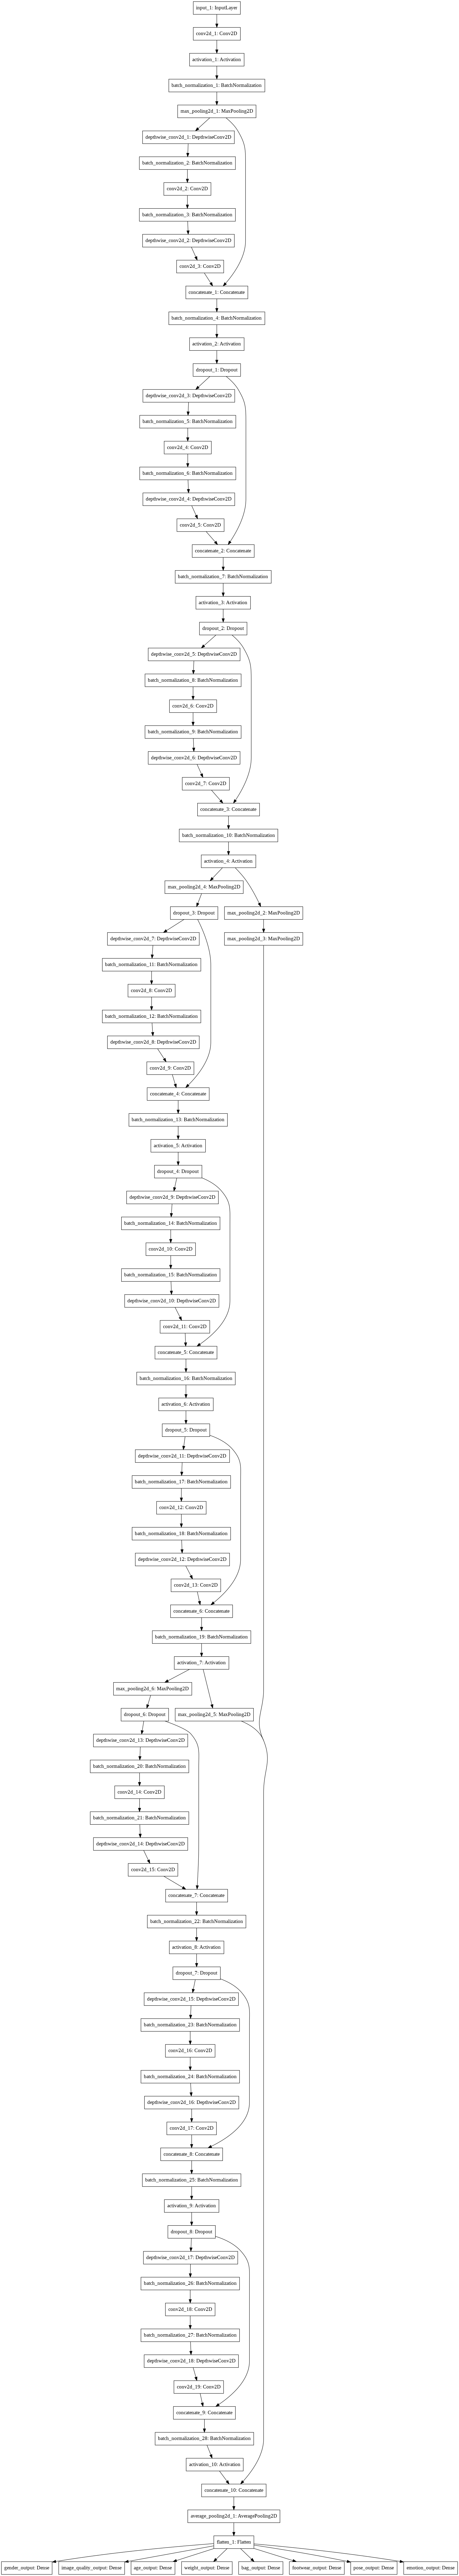

In [15]:
from keras.utils import plot_model
plot_model(model, to_file='convolutional_neural_network.png')

In [19]:
history=model.fit_generator(
    generator=train_gen,
    validation_data=valid_gen,
    use_multiprocessing=True,
    workers=6, 
    epochs=200,#epochs,
    verbose=1,callbacks=callbacks,
    #steps_per_epoch=1
) 

#apply cutout

Epoch 1/200
Learning rate:  0.001
180/180 [==============================] - 137s 761ms/step - loss: 5.9241 - gender_output_loss: 0.6798 - image_quality_output_loss: 1.4332 - age_output_loss: 2.0344 - weight_output_loss: 0.9934 - bag_output_loss: 0.9486 - footwear_output_loss: 0.9871 - pose_output_loss: 0.9401 - emotion_output_loss: 0.9222 - gender_output_acc: 0.5753 - image_quality_output_acc: 0.2321 - age_output_acc: 0.0562 - weight_output_acc: 0.6351 - bag_output_acc: 0.5502 - footwear_output_acc: 0.5269 - pose_output_acc: 0.6083 - emotion_output_acc: 0.7077 - val_loss: 5.8582 - val_gender_output_loss: 0.6661 - val_image_quality_output_loss: 1.4580 - val_age_output_loss: 2.0614 - val_weight_output_loss: 0.9837 - val_bag_output_loss: 0.9261 - val_footwear_output_loss: 0.9767 - val_pose_output_loss: 0.9048 - val_emotion_output_loss: 0.9491 - val_gender_output_acc: 0.5917 - val_image_quality_output_acc: 0.2288 - val_age_output_acc: 0.0575 - val_weight_output_acc: 0.6295 - val_bag_outpu